# pyPCGA modflow inversion example

In [1]:
%matplotlib  inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from pyPCGA import PCGA
import mf
import math
import datetime as dt
import os

- model domain and discretization

In [3]:
Lx = 1000.; Ly = 750.; Lz = 1; nlay = 1; nrow = 75; ncol = 100
Q = 25.; Rch = 0.001
ztop = 0.; zbot = -1.

- seems confusing, but python array order of col, row and lay

In [4]:
N = np.array([ncol, nrow, nlay])
m = np.prod(N)
dx = np.array([10., 10., 1.])
xmin = np.array([0. + dx[0] / 2., 0. + dx[1] / 2., 0. + dx[2] / 2.])
xmax = np.array([Lx - dx[0] / 2., Ly - dx[1] / 2., Lz - dx[2] / 2.])

- x,y coordinates for plotting

In [5]:
x = np.linspace(0. + dx[0] / 2., Lx - dx[0] / 2., N[0])
y = np.linspace(0. + dx[1] / 2., Ly - dx[1] / 2., N[1])
XX, YY = np.meshgrid(x, y)
pts = np.hstack((XX.ravel()[:, np.newaxis], YY.ravel()[:, np.newaxis]))

- specify executable and input/simulation directorys

In [6]:
if os.name == 'nt':
    mf_exec = 'mf2005.exe'
else:
    mf_exec = 'mf2005'

input_dir = "./input_files"
sim_dir = './simul'

- location of observations (obs_locmat)

In [7]:
obs_locmat = np.zeros((nlay, nrow, ncol), np.bool)
for i in range(5, 71, 16):
    for j in range(9, 96, 16):
        obs_locmat[0, i, j] = 1

- Hydraulic tomography - crosswell pumping test setting

In [8]:
Q_locs_idx = np.where(obs_locmat == True)
Q_locs = []
for Q_loc in zip(Q_locs_idx[0], Q_locs_idx[1], Q_locs_idx[2]):
    Q_locs.append(Q_loc)

- covairance kernel and scale parameters

In [9]:
prior_std = 1.0
prior_cov_scale = np.array([200., 200., 1.])

def kernel(r): return (prior_std ** 2) * np.exp(-r)

- load true value for comparison purpose

In [10]:
s_true = np.loadtxt('true_logK.txt')
s_true = np.array(s_true).reshape(-1, 1)  # make it 2D array

- load observations

In [11]:
obs = np.loadtxt('obs.txt')

- modflow parameters

In [12]:
mf_params = {'mf_exec': mf_exec, 'input_dir': input_dir,
          'sim_dir': sim_dir,
          'Lx': Lx, 'Ly': Ly,
          'Q': Q, 'Rch': Rch,
          'nlay': nlay, 'nrow': nrow, 'ncol': ncol,
          'zbot': zbot, 'ztop': ztop,
          'obs_locmat': obs_locmat, 'Q_locs': Q_locs}

- prepare interface to run as a function


In [13]:
def forward_model(s, parallelization, ncores=None):
    model = mf.Model(mf_params)

    if parallelization:
        simul_obs = model.run(s, parallelization, ncores)
    else:
        simul_obs = model.run(s, parallelization)
    return simul_obs

- inversion parameters

In [14]:
params = {'R': (0.5) ** 2, 'n_pc': 50,
          'maxiter': 10, 'restol': 0.01,
          'matvec': 'FFT', 'xmin': xmin, 'xmax': xmax, 'N': N,
          'prior_std': prior_std, 'prior_cov_scale': prior_cov_scale,
          'kernel': kernel, 'post_cov': "diag",
          'precond': True, 'LM': True,
          'parallel': True, 'linesearch': True,
          'forward_model_verbose': False, 'verbose': False,
          'iter_save': True}

- initial guess

In [15]:
s_init = np.ones((m, 1))

PCGA initialization

In [16]:
prob = PCGA(forward_model, s_init, pts, params, s_true, obs)

##### PCGA Inversion #####
##### 1. Initialize forward and inversion parameters
------------ Inversion Parameters -------------------------
   Number of unknowns                            : 7500
   Number of observations                        : 870
   Number of principal components (n_pc)         : 50
   Prior model                                   : def kernel(r): return (prior_std ** 2) * np.exp(-r)

   Prior variance                                : 1.000000e+00
   Prior scale (correlation) parameter           : [200. 200.   1.]
   Posterior cov computation                     : diag
   Posterior variance computation                  : Approx.
   Number of CPU cores (n_core)                  : 4
   Maximum GN iterations                         : 10
   machine precision (delta = sqrt(precision))   : 1.000000e-08
   Tol for iterations (norm(sol_diff)/norm(sol)) : 1.000000e-02
   Levenberg-Marquardt                           : True
   Line search                                   : 

In [17]:
s_hat, simul_obs, post_diagv, iter_best = prob.Run()

##### 2. Construct Prior Covariance Matrix
- time for covariance matrix construction (m = 7500) is 0 sec
##### 3. Eigendecomposition of Prior Covariance
- time for eigendecomposition with k = 50 is 1 sec
- 1st eigv : 1366.02, 50-th eigv : 13.8197, ratio: 0.0101168
##### 4. Start PCGA Inversion #####
-- evaluate initial solution
obs. RMSE (norm(obs. diff.)/sqrt(nobs)): 28.9211, normalized obs. RMSE (norm(obs. diff./sqrtR)/sqrt(nobs)): 57.8421
***** Iteration 1 ******
computed Jacobian-Matrix products in 37.474706 secs
solve saddle point (co-kriging) systems with Levenberg-Marquardt
evaluate LM solutions
- Geostat. inversion at iteration 1 is 40 sec
== iteration 1 summary ==
= objective function is 1.395409e+05, relative L2-norm diff btw sol 0 and sol 1 is 0.838276
= L2-norm error (w.r.t truth) is 0.365869, obs. RMSE is 8.95511, obs. normalized RMSE is 17.9102
- save results in text at iteration 1
***** Iteration 2 ******
computed Jacobian-Matrix products in 38.668834 secs
solve saddle p

- post processing

In [18]:
s_hat3d = s_hat.reshape(nlay, nrow, ncol)
s_hat2d = s_hat3d[0,:,:]
s_true3d = s_true.reshape(nlay, nrow, ncol)
s_true2d = s_true3d[0,:,:]

post_diagv[post_diagv < 0.] = 0.  # just in case
post_std = np.sqrt(post_diagv)
post_std3d = post_std.reshape(nlay, nrow, ncol)
post_std2d = post_std3d[0,:,:]

minv = s_true.min()
maxv = s_true.max()

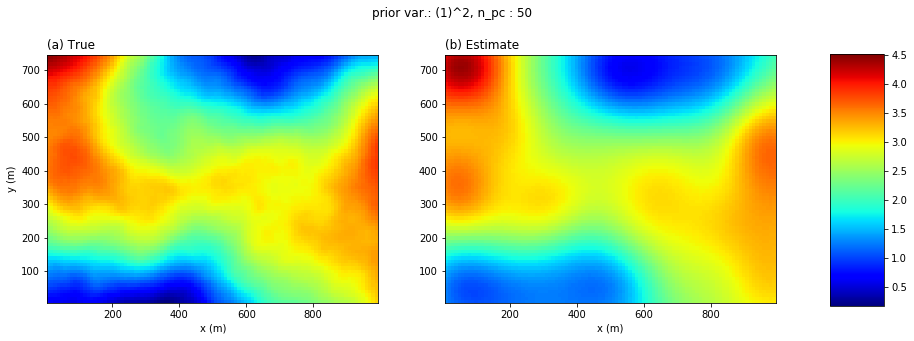

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle('prior var.: (%g)^2, n_pc : %d' % (prior_std, params['n_pc']))
im = axes[0].pcolormesh(XX,YY,s_true2d, vmin=minv, vmax=maxv, cmap=plt.get_cmap('jet'))
axes[0].set_title('(a) True', loc='left')
axes[0].set_aspect('equal')
axes[0].set_xlabel('x (m)')
axes[0].set_ylabel('y (m)')
axes[0].axis([XX.min(), XX.max(), YY.min(), YY.max()])
axes[1].pcolormesh(XX, YY, s_hat2d, vmin=minv, vmax=maxv, cmap=plt.get_cmap('jet'))
axes[1].set_title('(b) Estimate', loc='left')
axes[1].set_xlabel('x (m)')
axes[1].set_aspect('equal')
axes[1].axis([XX.min(), XX.max(), YY.min(), YY.max()])

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()
plt.close(fig)

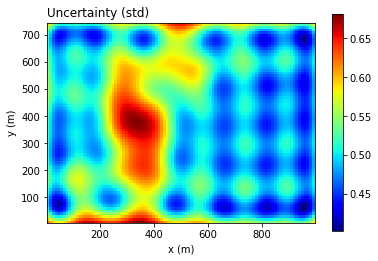

In [20]:
fig = plt.figure()
im = plt.pcolormesh(XX,YY,post_std2d, cmap=plt.get_cmap('jet'))
plt.axis([XX.min(), XX.max(), YY.min(), YY.max()])
plt.title('Uncertainty (std)', loc='left')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.gca().set_aspect('equal', adjustable='box')
fig.colorbar(im)
plt.show()
plt.close(fig)

- observation mismatch

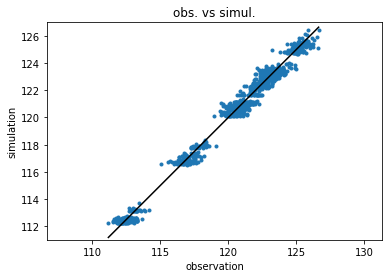

In [21]:
nobs = prob.obs.shape[0]
fig = plt.figure()
plt.title('obs. vs simul.')
plt.plot(prob.obs, simul_obs, '.')
plt.xlabel('observation')
plt.ylabel('simulation')
minobs = np.vstack((prob.obs, simul_obs)).min(0)
maxobs = np.vstack((prob.obs, simul_obs)).max(0)
plt.plot(np.linspace(minobs, maxobs, 20), np.linspace(minobs, maxobs, 20), 'k-')
plt.axis('equal')
axes = plt.gca()
axes.set_xlim([math.floor(minobs), math.ceil(maxobs)])
axes.set_ylim([math.floor(minobs), math.ceil(maxobs)])
plt.show()
plt.close(fig)

- objective values

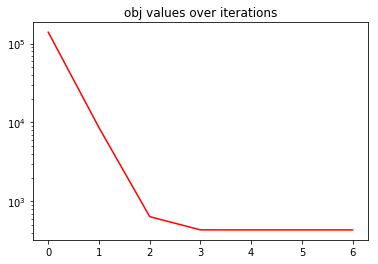

In [22]:
fig = plt.figure()
plt.semilogy(range(len(prob.objvals)), prob.objvals, 'r-')
plt.title('obj values over iterations')
plt.axis('tight')
plt.show()
plt.close(fig)

- eigenvectors

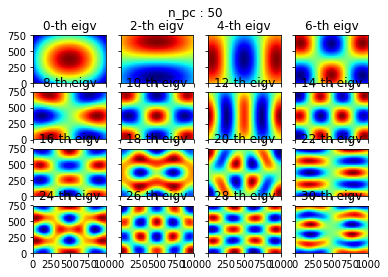

In [26]:
fig, axes = plt.subplots(4, 4, sharex=True, sharey=True)
fig.suptitle('n_pc : %d' % params['n_pc'])
for i in range(4):
    for j in range(4):
        tmp3d = prob.priorU[:, (i * 4 + j) * 2].reshape(nlay,nrow,ncol)
        axes[i, j].pcolormesh(XX,YY,tmp3d[0,:,:],cmap=plt.get_cmap('jet'))
        axes[i, j].set_title('%d-th eigv' % ((i * 4 + j) * 2))
        axes[i, j].axis([XX.min(), XX.max(), YY.min(), YY.max()])
plt.show()
plt.close(fig)

- eigenvalue decay

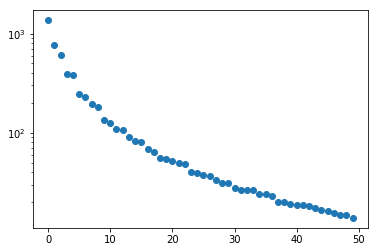

In [25]:
fig = plt.figure()
plt.semilogy(prob.priord, 'o')
fig.savefig('eig.png', dpi=fig.dpi)
plt.show()
plt.close(fig)